In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

%matplotlib inline

In [2]:
PATH = Path('.')

In [3]:
device = "cuda:6" if torch.cuda.is_available() else "cpu"

In [4]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [5]:
train_ds = datasets.MNIST(PATH / "MNIST", train=True, transform=tfms, download=True)
test_ds = datasets.MNIST(PATH / "MNIST", train=False, transform=tfms, download=True)

In [6]:
train_dl = data.DataLoader(train_ds, batch_size=36)
test_dl = data.DataLoader(test_ds, batch_size=36, shuffle=False)

In [7]:
def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [8]:
def plot_losses(trn_losses, tst_losses):
    plt.figure(figsize=(12,6))
    plt.plot(tst_losses, color='green', label="test")
    plt.plot(trn_losses, color='blue', label="train")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

In [9]:
def plot_ae(ae, img):
    ae.eval()
    output = ae(img.to(device))
    plot_mnist(img, (6,6))
    plot_mnist(output.data.cpu().numpy(), (6,6))

In [10]:
class ConvLayer(nn.Module):
    def __init__(self, sz, bn=False, dp=False, a_fn=nn.ReLU(), pl = nn.MaxPool2d(2, stride=2), **kwargs):
        super().__init__()
        layers = []
        layers.append(nn.Conv2d(sz[0], sz[1], sz[2], **kwargs))
        if pl:
            layers.append(pl)
        if bn:
            layers.append(nn.BatchNorm2d(sz[1]))
        if dp:
            layers.append(nn.Dropout2d())
        layers.append(a_fn)
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [11]:
class ConvTLayer(nn.Module):
    def __init__(self, sz, bn=False, dp=False, a_fn=nn.ReLU(), **kwargs):
        super().__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(sz[0], sz[1], sz[2], **kwargs))
        if bn:
            layers.append(nn.BatchNorm2d(sz[1]))
        if dp:
            layers.append(nn.Dropout2d())
        layers.append(a_fn)
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [12]:
class LinearLayer(nn.Module):
    def __init__(self, sz, bn=False, dp=False, a_fn=nn.ReLU(), **kwargs):
        super().__init__()
        layers = []
        
        for i in range(len(sz)-2):
            layers.append(nn.Linear(sz[i], sz[i+1]))
            if bn:
                layers.append(nn.BatchNorm1d(sz[i+1]))
            if dp:
                layers.append(nn.Dropout())
            layers.append(a_fn)
        layers.append(nn.Linear(sz[-2], sz[-1]))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [13]:
class ConvolutionalAE(nn.Module):
    def __init__(self, linear_sizes=None, bn=False, dp=False):
        super().__init__()
        self.linear_sizes = linear_sizes
        self.name = f'ConvAE BN={bn} DP={dp} FC={self.linear_sizes}'
        a_fn = nn.ReLU() if linear_sizes else nn.Tanh()
        self.cnn_encoder = nn.Sequential(
            ConvLayer((1,16,3), bn=bn, dp=dp, padding=1),
            ConvLayer((16,32,3), bn=bn, dp=dp, a_fn=a_fn, padding=1)
        )
        if linear_sizes:
            self.fc_encoder = nn.Sequential(
                LinearLayer([32*7*7, *linear_sizes], bn=bn, dp=dp),
                nn.Tanh()
            )

            self.fc_decoder = nn.Sequential(
                LinearLayer([*linear_sizes, 32*7*7], bn=bn, dp=dp),
                nn.ReLU()
            )

        self.cnn_decoder = nn.Sequential(
            ConvTLayer((32,16,3), bn=bn, dp=dp, stride=2),
            ConvTLayer((16,1,3), bn=False, dp=False, a_fn=nn.Tanh(), padding=2, stride=2, output_padding=1)
        )
        """
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # 16 x 28 x 28,
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, stride=2),  # 16 x 14 x 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),  # 32 x 14 x 14
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=2),  # 32 x 7 x 7
        )
        self.fc_encoder = nn.Sequential(
            nn.Linear(32*7*7, linear_sizes[0]),
            nn.BatchNorm1d(linear_sizes[0]),
            nn.ReLU(),
            nn.Linear(linear_sizes[0], linear_sizes[1]),
            nn.Tanh()
        )
        
        self.fc_decoder = nn.Sequential(
            nn.Linear(linear_sizes[1], linear_sizes[0]),
            nn.BatchNorm1d(linear_sizes[0]),
            nn.ReLU(),
            nn.Linear(linear_sizes[0], 32*7*7),
            nn.BatchNorm1d(32*7*7),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2), # 16 x 15 x 15
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, padding=2, stride=2, output_padding=1), # 1 x 28 x 28
            nn.Tanh()
        )
        """
        self.optim = optim.Adam(self.parameters(), lr=1e-4)
        self._loss = None
        
    def forward(self, x):
        x =self.cnn_encoder(x)
        if self.linear_sizes:
            x = F.relu(x)
            x = x.view(x.shape[0], -1)
            x = self.fc_encoder(x)
            x = self.fc_decoder(x)
            x = x.view(x.shape[0], 32, 7, 7)
        else:
            x = F.tanh(x)
        x = self.cnn_decoder(x)
        
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.mse_loss(output, target, **kwargs)
        return self._loss

In [14]:
models = [ConvolutionalAE().to(device)]

In [15]:
for m in models:
    print(f"\n------------- {m.name} -------------\n")
    print(m)


------------- ConvAE BN=False DP=False FC=None -------------

ConvolutionalAE(
  (cnn_encoder): Sequential(
    (0): ConvLayer(
      (model): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU()
      )
    )
    (1): ConvLayer(
      (model): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): Tanh()
      )
    )
  )
  (cnn_decoder): Sequential(
    (0): ConvTLayer(
      (model): Sequential(
        (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
        (1): ReLU()
      )
    )
    (1): ConvTLayer(
      (model): Sequential(
        (0): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
        (1): Tanh()
      )
    )
  )
)


In [16]:
def train(models, train_dl, test_dl):
    train_loss = [0.]*len(models)
    train_size = len(train_dl)
    
    test_loss = [0.]*len(models)
    test_size = len(test_dl)
    
    for data, _ in train_dl:
        data = data.to(device)
        for i, m in enumerate(models):
            m.train()
            m.optim.zero_grad()
            output = m(data)
            loss = m.loss(output, data)
            loss.backward()
            m.optim.step()
            train_loss[i] += m._loss.item()
        
    for data, _ in test_dl:
        data = data.to(device)
        for i, m in enumerate(models):
            m.eval()
            output = m(data)
            loss = m.loss(output, data)
            test_loss[i] += m._loss.item()

    print(f"Epoch {epoch}:")
    for i, m in enumerate(models):
        train_loss[i] /= train_size
        test_loss[i] /= test_size
        print("  Loss for {0:45s}: {1:2.5f} / {2:2.5f}".format(m.name, train_loss[i], test_loss[i]))
        
    return zip(train_loss, test_loss)

In [17]:
train_losses = [[] for i in range(len(models))]
test_losses = [[] for i in range(len(models))]

Epoch 1:
  Loss for ConvAE BN=False DP=False FC=None             : 0.17086 / 0.04264
Epoch 2:
  Loss for ConvAE BN=False DP=False FC=None             : 0.03158 / 0.02284
Epoch 3:
  Loss for ConvAE BN=False DP=False FC=None             : 0.01990 / 0.01649
Epoch 4:
  Loss for ConvAE BN=False DP=False FC=None             : 0.01557 / 0.01378
Epoch 5:
  Loss for ConvAE BN=False DP=False FC=None             : 0.01348 / 0.01232
Epoch 6:
  Loss for ConvAE BN=False DP=False FC=None             : 0.01225 / 0.01138
Epoch 7:
  Loss for ConvAE BN=False DP=False FC=None             : 0.01140 / 0.01069
Epoch 8:
  Loss for ConvAE BN=False DP=False FC=None             : 0.01074 / 0.01014
Epoch 9:
  Loss for ConvAE BN=False DP=False FC=None             : 0.01020 / 0.00968
Epoch 10:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00975 / 0.00930

------------- ConvAE BN=False DP=False FC=None -------------



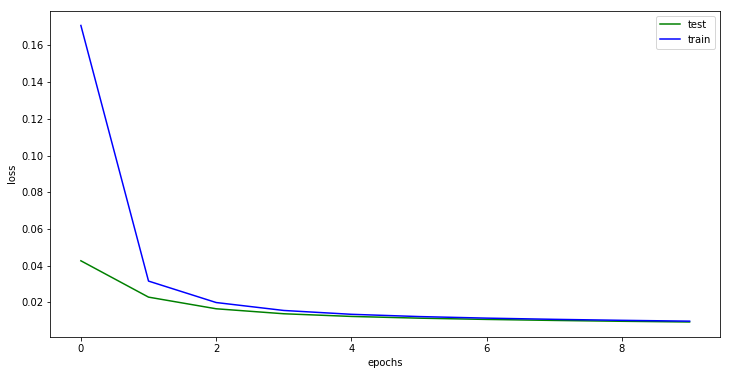

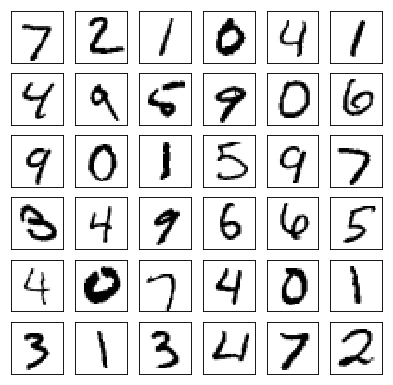

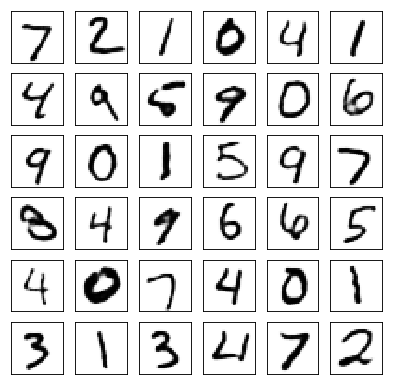

Epoch 11:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00937 / 0.00898
Epoch 12:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00905 / 0.00871
Epoch 13:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00877 / 0.00847
Epoch 14:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00852 / 0.00825
Epoch 15:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00830 / 0.00805
Epoch 16:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00810 / 0.00787
Epoch 17:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00792 / 0.00770
Epoch 18:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00775 / 0.00754
Epoch 19:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00759 / 0.00740
Epoch 20:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00745 / 0.00726

------------- ConvAE BN=False DP=False FC=None -------------



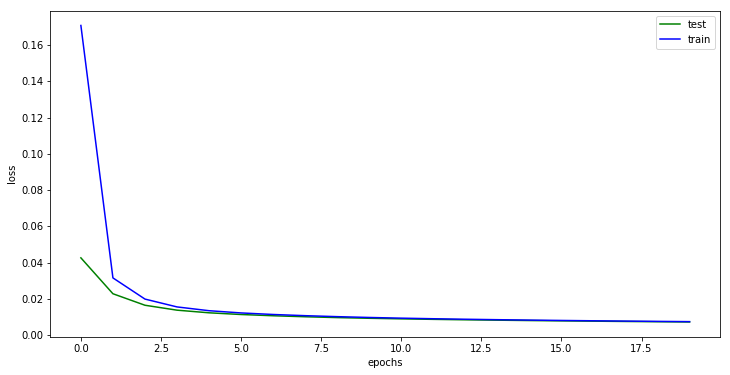

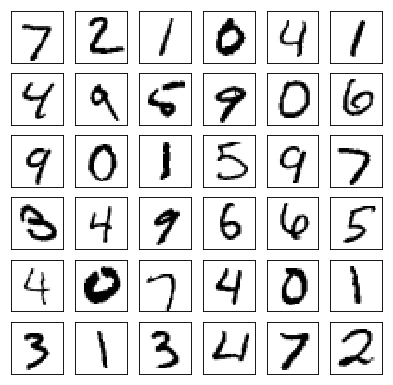

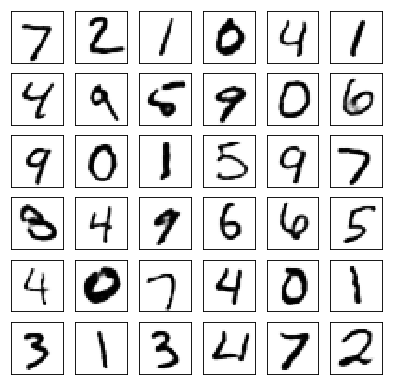

Epoch 21:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00732 / 0.00714
Epoch 22:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00720 / 0.00702
Epoch 23:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00709 / 0.00692
Epoch 24:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00698 / 0.00682
Epoch 25:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00689 / 0.00673
Epoch 26:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00680 / 0.00665
Epoch 27:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00672 / 0.00657
Epoch 28:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00664 / 0.00650
Epoch 29:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00657 / 0.00643
Epoch 30:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00650 / 0.00637

------------- ConvAE BN=False DP=False FC=None -------------



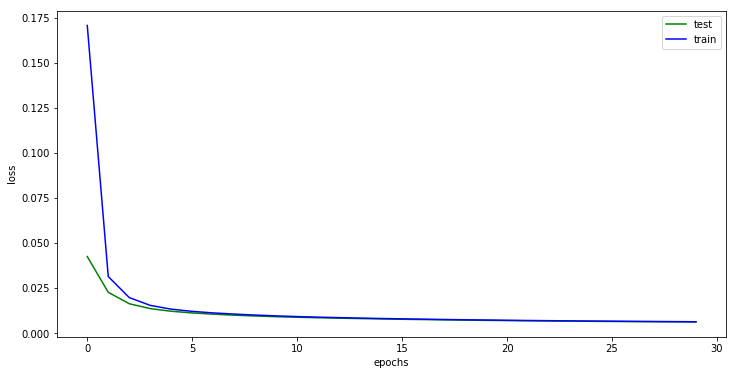

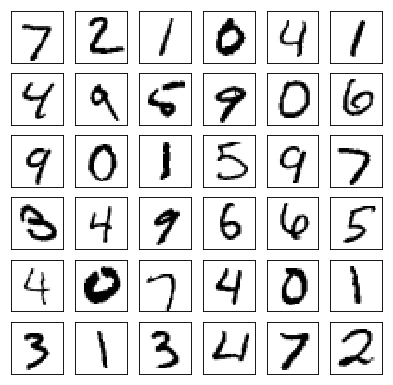

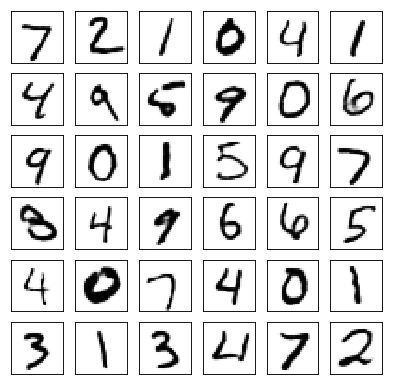

Epoch 31:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00644 / 0.00630
Epoch 32:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00637 / 0.00625
Epoch 33:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00632 / 0.00619
Epoch 34:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00626 / 0.00614
Epoch 35:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00621 / 0.00609
Epoch 36:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00616 / 0.00604
Epoch 37:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00611 / 0.00600
Epoch 38:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00606 / 0.00595
Epoch 39:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00602 / 0.00591
Epoch 40:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00598 / 0.00587

------------- ConvAE BN=False DP=False FC=None -------------



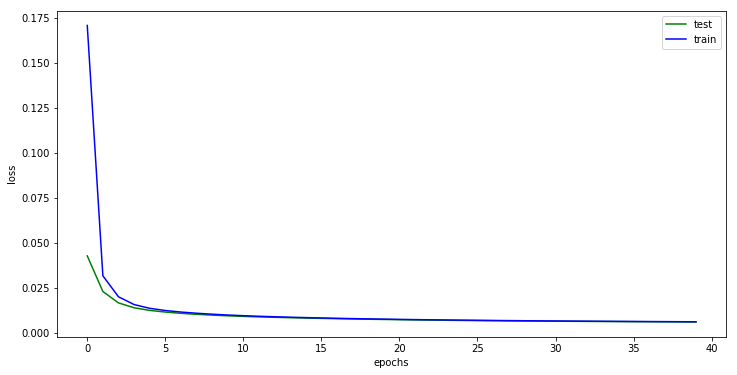

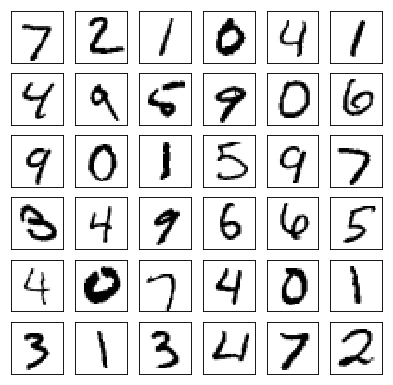

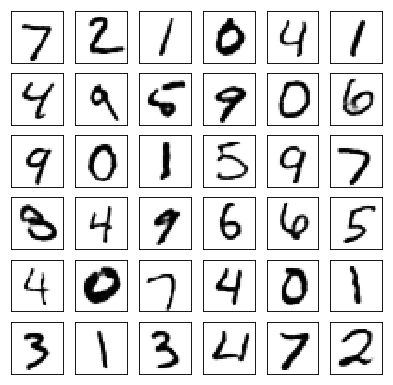

Epoch 41:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00594 / 0.00583
Epoch 42:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00590 / 0.00580
Epoch 43:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00586 / 0.00576
Epoch 44:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00583 / 0.00573
Epoch 45:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00579 / 0.00569
Epoch 46:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00576 / 0.00566
Epoch 47:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00572 / 0.00563
Epoch 48:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00569 / 0.00560
Epoch 49:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00566 / 0.00557
Epoch 50:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00563 / 0.00554

------------- ConvAE BN=False DP=False FC=None -------------



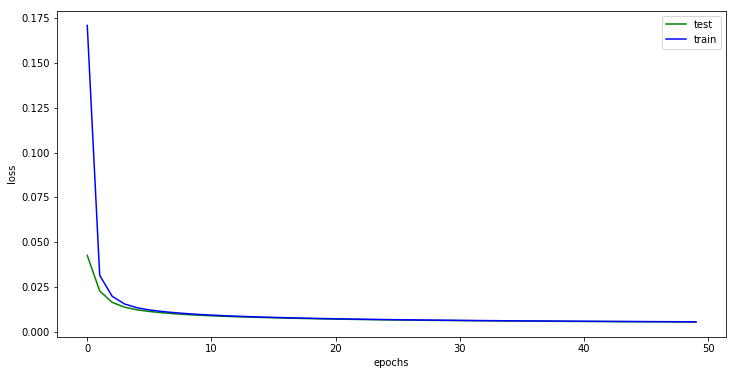

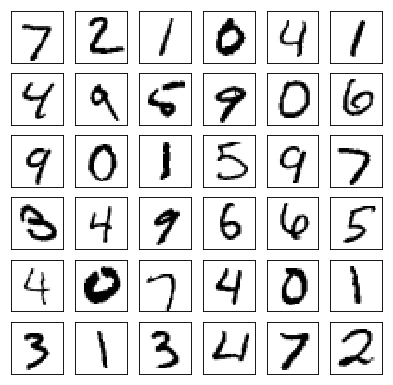

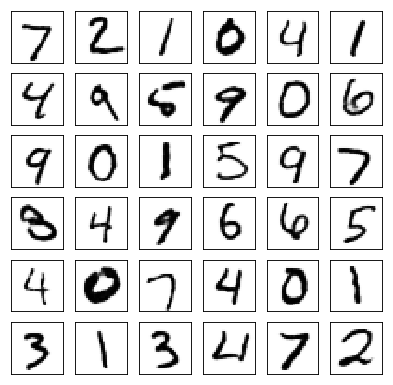

CPU times: user 11min 47s, sys: 22.5 s, total: 12min 10s
Wall time: 11min 58s


In [18]:
%%time
for epoch in range(1, 51):
    losses = train(models, train_dl, test_dl)
    
    for i, (trn, tst) in enumerate(losses):
        train_losses[i].append(trn)
        test_losses[i].append(tst)
    
    if epoch % 10 == 0:
        for i, m in enumerate(models):
            print(f"\n------------- {m.name} -------------\n")
            plot_losses(train_losses[i], test_losses[i])
            img, _ = next(iter(test_dl))
            plot_ae(m, img)



In [19]:
#for m in models:
#    torch.save(m.state_dict(), PATH / f'{m.name}.model')

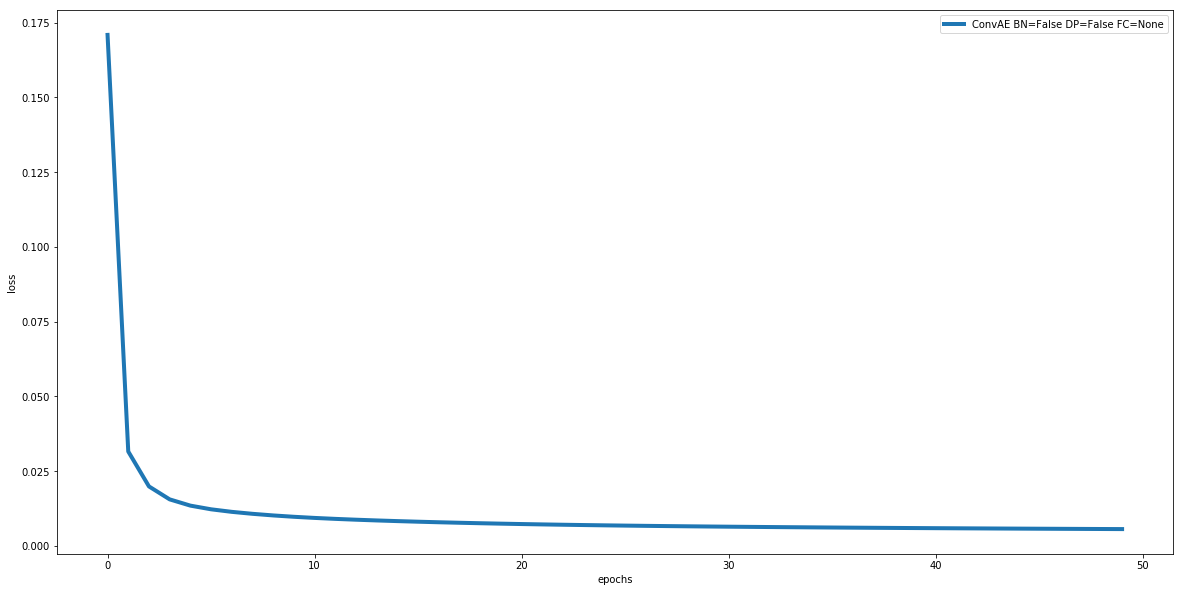

In [20]:
plt.figure(figsize=(20,10))

for i, m in enumerate(models):
    line = train_losses[i]
    if "FC=None" in m.name:
        plt.plot(line, label=m.name, linestyle='-',
        linewidth=4)
    elif "BN=True" in m.name and "DP=False" in m.name:
        plt.plot(line, label=m.name, marker='o', linestyle='-',
        linewidth=2, markersize=6)
    elif "BN=True" in m.name and "DP=True" in m.name:
        plt.plot(line, label=m.name, marker='|', linestyle='-',
        linewidth=2, markersize=6)
    else:
        plt.plot(line, label=m.name, marker='^', linestyle=':',
        linewidth=2, markersize=6)
        
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

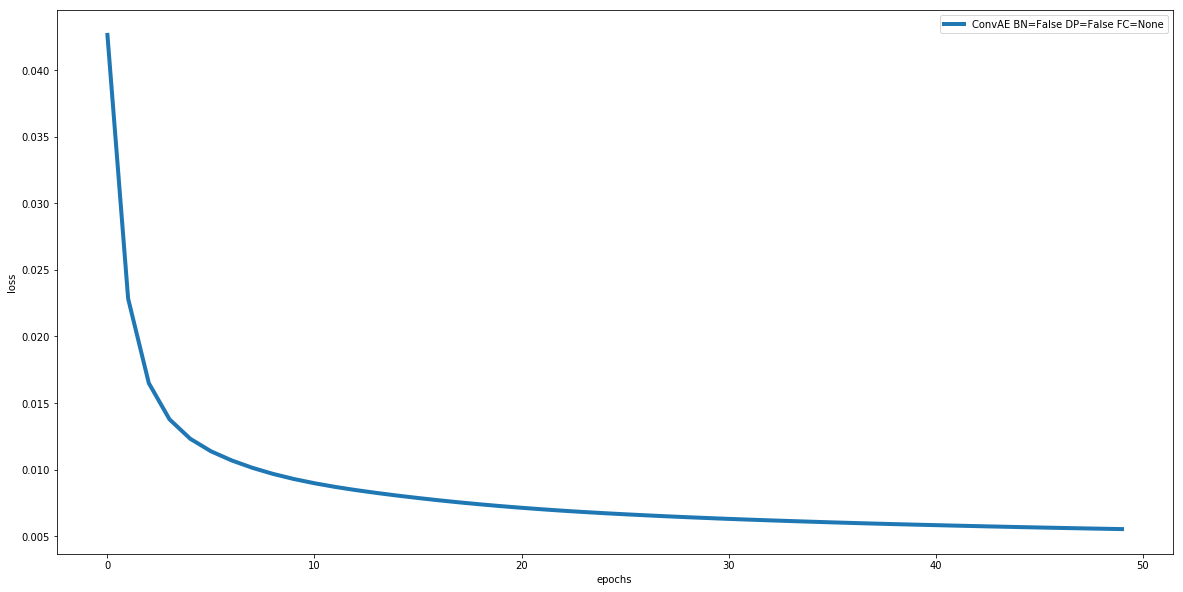

In [21]:
plt.figure(figsize=(20,10))

for i, m in enumerate(models):
    line = test_losses[i]
    if "FC=None" in m.name:
        plt.plot(line, label=m.name, linestyle='-',
        linewidth=4)
    elif "BN=True" in m.name and "DP=False" in m.name:
        plt.plot(line, label=m.name, marker='o', linestyle='-',
        linewidth=2, markersize=6)
    elif "BN=True" in m.name and "DP=True" in m.name:
        plt.plot(line, label=m.name, marker='|', linestyle='-',
        linewidth=2, markersize=6)
    else:
        plt.plot(line, label=m.name, marker='^', linestyle=':',
        linewidth=2, markersize=6)
        
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [22]:
class FitImageToMaxActivationModel(nn.Module):
    def __init__(self, image, n=0, clip_fn=F.tanh):
        super().__init__()
        self.n = n
        self.image = nn.Parameter(image)
        self.optim = optim.Adam(self.parameters(), lr=1e-4)
        self._loss = None
        self.clip_fn = clip_fn if clip_fn else lambda x: x
        
    def forward(self, encoder):
        x = self.image
        out = encoder(self.clip_fn(x))
        return out
    
    def loss(self, output):
        self._loss = -output[:,self.n,:,:].sum()
        return self._loss

In [23]:
def fit_image_to_activation(sz, n, encoder, n_iter = 10_001, n_print = 10_000):
    torch.manual_seed(42)
    
    origin = torch.zeros(*sz)
    
    encoder.eval()

    ms = {
        'target': FitImageToMaxActivationModel(torch.tensor(origin).to(device), n)
    }

    opt_losses = [[] for i in range(len(ms))]

    for m in ms.values():
        m.to(device).train()

    for i in range(1, n_iter):
        losses = [0.0]*len(ms)
        for j , m in enumerate(ms.values()):
            m.optim.zero_grad()
            out = m(encoder)
            loss = m.loss(out)
            loss.backward()
            m.optim.step()
            losses[j]+=loss.item()
        if i % n_print == 0:
            for k in range(len(ms)):
                opt_losses[k].append(losses[k])
            s = ["\t{0:10s} = {1:2.10f}\n".format(m, losses[j]) for j , m in enumerate(ms)]
            line = f"{int(i/1000)}K iteration loss: \n{' '.join(s)}"
            print(line)
            losses = [0.0]*len(ms)
    for m in ms.values():
        m.eval()
        target_imgs = {k: m.image.detach() for k, m in ms.items()}

    print(f'Max activation pattern for neuron #{n}')
    target = target_imgs['target']
    plot_mnist(F.tanh(target).data.cpu().numpy(), (1,1))
    return target

In [24]:
models[0].eval()

ConvolutionalAE(
  (cnn_encoder): Sequential(
    (0): ConvLayer(
      (model): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU()
      )
    )
    (1): ConvLayer(
      (model): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): Tanh()
      )
    )
  )
  (cnn_decoder): Sequential(
    (0): ConvTLayer(
      (model): Sequential(
        (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
        (1): ReLU()
      )
    )
    (1): ConvTLayer(
      (model): Sequential(
        (0): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
        (1): Tanh()
      )
    )
  )
)

In [25]:
encoder = nn.Sequential(
    models[0].cnn_encoder[0]
)
encoder.eval()
encoder

Sequential(
  (0): ConvLayer(
    (model): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
    )
  )
)

25K iteration loss: 
	target     = -1.3873907328

50K iteration loss: 
	target     = -1.4147037268

Max activation pattern for neuron #0


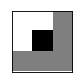

25K iteration loss: 
	target     = -1.3401236534

50K iteration loss: 
	target     = -1.3583818674

Max activation pattern for neuron #1


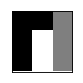

25K iteration loss: 
	target     = -1.2896044254

50K iteration loss: 
	target     = -1.3158205748

Max activation pattern for neuron #2


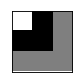

25K iteration loss: 
	target     = -1.3052477837

50K iteration loss: 
	target     = -1.3264560699

Max activation pattern for neuron #3


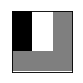

25K iteration loss: 
	target     = -1.0931485891

50K iteration loss: 
	target     = -1.1112744808

Max activation pattern for neuron #4


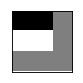

25K iteration loss: 
	target     = 0.0000000000

50K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #5


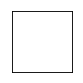

25K iteration loss: 
	target     = -1.0426061153

50K iteration loss: 
	target     = -1.0595201254

Max activation pattern for neuron #6


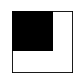

25K iteration loss: 
	target     = -0.8570042849

50K iteration loss: 
	target     = -0.8756915927

Max activation pattern for neuron #7


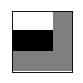

25K iteration loss: 
	target     = -1.4667086601

50K iteration loss: 
	target     = -1.4927568436

Max activation pattern for neuron #8


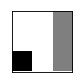

25K iteration loss: 
	target     = -1.9266207218

50K iteration loss: 
	target     = -1.9680776596

Max activation pattern for neuron #9


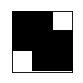

25K iteration loss: 
	target     = 0.0000000000

50K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #10


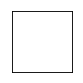

25K iteration loss: 
	target     = -1.5638126135

50K iteration loss: 
	target     = -1.5869925022

Max activation pattern for neuron #11


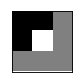

25K iteration loss: 
	target     = 0.0000000000

50K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #12


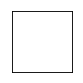

25K iteration loss: 
	target     = -1.2928258181

50K iteration loss: 
	target     = -1.3218637705

Max activation pattern for neuron #13


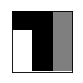

25K iteration loss: 
	target     = -0.8139470220

50K iteration loss: 
	target     = -0.8297015429

Max activation pattern for neuron #14


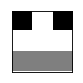

25K iteration loss: 
	target     = -1.6342390776

50K iteration loss: 
	target     = -1.6697541475

Max activation pattern for neuron #15


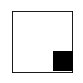

CPU times: user 11min 53s, sys: 32 s, total: 12min 25s
Wall time: 12min 26s


In [26]:
%%time
targets1 = []
for i in range(16):
    t = fit_image_to_activation((1,1,3,3), i, encoder, n_iter=50_001, n_print=25_000)
    targets1.append(t)

In [30]:
encoder2 = nn.Sequential(
    models[0].cnn_encoder[0],
    models[0].cnn_encoder[1]
) 
encoder2.eval()
encoder2

Sequential(
  (0): ConvLayer(
    (model): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
    )
  )
  (1): ConvLayer(
    (model): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Tanh()
    )
  )
)

25K iteration loss: 
	target     = -0.9422402382

50K iteration loss: 
	target     = -0.9487465024

Max activation pattern for neuron #0


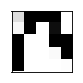

25K iteration loss: 
	target     = -0.3099273741

50K iteration loss: 
	target     = -0.3265770972

Max activation pattern for neuron #1


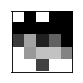

25K iteration loss: 
	target     = -0.4302197695

50K iteration loss: 
	target     = -0.4457655251

Max activation pattern for neuron #2


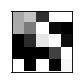

25K iteration loss: 
	target     = -0.6018292904

50K iteration loss: 
	target     = -0.6192892790

Max activation pattern for neuron #3


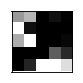

25K iteration loss: 
	target     = -0.9928753972

50K iteration loss: 
	target     = -0.9943996072

Max activation pattern for neuron #4


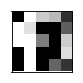

25K iteration loss: 
	target     = -0.8449231386

50K iteration loss: 
	target     = -0.8656173944

Max activation pattern for neuron #5


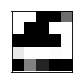

25K iteration loss: 
	target     = -0.8363218307

50K iteration loss: 
	target     = -0.8461505175

Max activation pattern for neuron #6


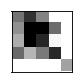

25K iteration loss: 
	target     = -0.5739237666

50K iteration loss: 
	target     = -0.6047339439

Max activation pattern for neuron #7


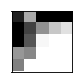

25K iteration loss: 
	target     = -0.3491029143

50K iteration loss: 
	target     = -0.3645317554

Max activation pattern for neuron #8


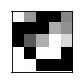

25K iteration loss: 
	target     = -0.9622845650

50K iteration loss: 
	target     = -0.9672012925

Max activation pattern for neuron #9


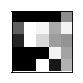

25K iteration loss: 
	target     = -0.5110720396

50K iteration loss: 
	target     = -0.5226868391

Max activation pattern for neuron #10


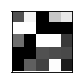

25K iteration loss: 
	target     = -0.9874358773

50K iteration loss: 
	target     = -0.9898995757

Max activation pattern for neuron #11


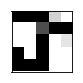

25K iteration loss: 
	target     = -0.9887043238

50K iteration loss: 
	target     = -0.9909570217

Max activation pattern for neuron #12


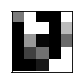

25K iteration loss: 
	target     = -0.8988770247

50K iteration loss: 
	target     = -0.9107165337

Max activation pattern for neuron #13


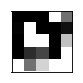

25K iteration loss: 
	target     = -0.8320450783

50K iteration loss: 
	target     = -0.8420926929

Max activation pattern for neuron #14


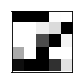

25K iteration loss: 
	target     = -0.7959219813

50K iteration loss: 
	target     = -0.8124278784

Max activation pattern for neuron #15


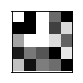

25K iteration loss: 
	target     = -0.8821231723

50K iteration loss: 
	target     = -0.8945840597

Max activation pattern for neuron #16


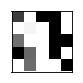

25K iteration loss: 
	target     = -0.6503439546

50K iteration loss: 
	target     = -0.6618725061

Max activation pattern for neuron #18


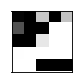

25K iteration loss: 
	target     = -0.9970822334

50K iteration loss: 
	target     = -0.9981012344

Max activation pattern for neuron #19


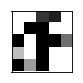

25K iteration loss: 
	target     = -0.6054811478

50K iteration loss: 
	target     = -0.6167218685

Max activation pattern for neuron #22


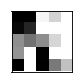

25K iteration loss: 
	target     = -0.4031347930

50K iteration loss: 
	target     = -0.4218896031

Max activation pattern for neuron #23


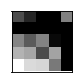

25K iteration loss: 
	target     = -0.8632559776

50K iteration loss: 
	target     = -0.8741093278

Max activation pattern for neuron #24


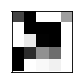

25K iteration loss: 
	target     = -0.7249101996

50K iteration loss: 
	target     = -0.7371823192

Max activation pattern for neuron #25


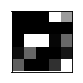

25K iteration loss: 
	target     = -0.5359805822

50K iteration loss: 
	target     = -0.5516688824

Max activation pattern for neuron #26


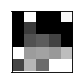

25K iteration loss: 
	target     = -0.9999987483

50K iteration loss: 
	target     = -0.9999998212

Max activation pattern for neuron #27


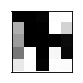

25K iteration loss: 
	target     = -0.8565710783

50K iteration loss: 
	target     = -0.8690228462

Max activation pattern for neuron #28


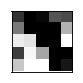

25K iteration loss: 
	target     = -0.9611893892

50K iteration loss: 
	target     = -0.9706056714

Max activation pattern for neuron #29


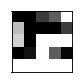

25K iteration loss: 
	target     = -0.9391327500

50K iteration loss: 
	target     = -0.9454168081

Max activation pattern for neuron #30


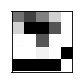

25K iteration loss: 
	target     = -0.8066323400

50K iteration loss: 
	target     = -0.8426849246

Max activation pattern for neuron #31


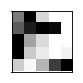

In [31]:
targets2 = []
for i in range(32):
    t = fit_image_to_activation((1,1,5,5), i, encoder2, n_iter=50_001, n_print=25_000)
    targets2.append(t)

25K iteration loss: 
	target     = -0.9422407746

50K iteration loss: 
	target     = -0.9487466216

Max activation pattern for neuron #0


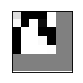

25K iteration loss: 
	target     = -0.2711274922

50K iteration loss: 
	target     = -0.3139934242

Max activation pattern for neuron #1


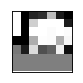

25K iteration loss: 
	target     = -0.4565764368

50K iteration loss: 
	target     = -0.4733360112

Max activation pattern for neuron #2


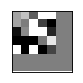

25K iteration loss: 
	target     = -0.6018384099

50K iteration loss: 
	target     = -0.6192889214

Max activation pattern for neuron #3


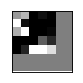

25K iteration loss: 
	target     = -0.9951821566

50K iteration loss: 
	target     = -0.9965049624

Max activation pattern for neuron #4


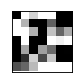

25K iteration loss: 
	target     = -0.9909866452

50K iteration loss: 
	target     = -0.9934001565

Max activation pattern for neuron #5


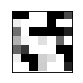

25K iteration loss: 
	target     = -0.8538345695

50K iteration loss: 
	target     = -0.8654886484

Max activation pattern for neuron #6


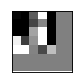

25K iteration loss: 
	target     = -0.5805536509

50K iteration loss: 
	target     = -0.6040036082

Max activation pattern for neuron #7


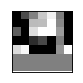

25K iteration loss: 
	target     = -0.3490968347

50K iteration loss: 
	target     = -0.3645338118

Max activation pattern for neuron #8


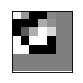

25K iteration loss: 
	target     = -0.9932247400

50K iteration loss: 
	target     = -0.9948987961

Max activation pattern for neuron #9


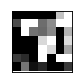

25K iteration loss: 
	target     = -0.5263025761

50K iteration loss: 
	target     = -0.5384142399

Max activation pattern for neuron #10


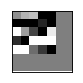

25K iteration loss: 
	target     = -0.9927176237

50K iteration loss: 
	target     = -0.9952152371

Max activation pattern for neuron #11


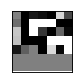

25K iteration loss: 
	target     = -0.9981241822

50K iteration loss: 
	target     = -0.9988079071

Max activation pattern for neuron #12


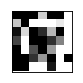

25K iteration loss: 
	target     = -0.9733217955

50K iteration loss: 
	target     = -0.9785873294

Max activation pattern for neuron #13


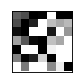

25K iteration loss: 
	target     = -0.9564089179

50K iteration loss: 
	target     = -0.9629680514

Max activation pattern for neuron #14


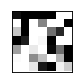

25K iteration loss: 
	target     = -0.9771218896

50K iteration loss: 
	target     = -0.9814612269

Max activation pattern for neuron #15


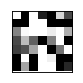

25K iteration loss: 
	target     = -0.9337762594

50K iteration loss: 
	target     = -0.9478145838

Max activation pattern for neuron #16


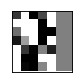

25K iteration loss: 
	target     = -0.9963841438

50K iteration loss: 
	target     = -0.9975865483

Max activation pattern for neuron #17


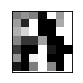

25K iteration loss: 
	target     = -0.4569953382

50K iteration loss: 
	target     = -0.4773949087

Max activation pattern for neuron #18


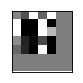

25K iteration loss: 
	target     = -0.9982823133

50K iteration loss: 
	target     = -0.9989318848

Max activation pattern for neuron #19


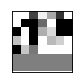

25K iteration loss: 
	target     = -0.9924569130

50K iteration loss: 
	target     = -0.9940990210

Max activation pattern for neuron #20


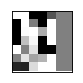

25K iteration loss: 
	target     = -0.5408326983

50K iteration loss: 
	target     = -0.5586549044

Max activation pattern for neuron #21


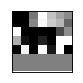

25K iteration loss: 
	target     = -0.8076678514

50K iteration loss: 
	target     = -0.8182576299

Max activation pattern for neuron #22


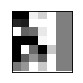

25K iteration loss: 
	target     = -0.4031075239

50K iteration loss: 
	target     = -0.4218887091

Max activation pattern for neuron #23


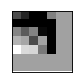

25K iteration loss: 
	target     = -0.9504072070

50K iteration loss: 
	target     = -0.9589143991

Max activation pattern for neuron #24


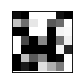

25K iteration loss: 
	target     = -0.7249113321

50K iteration loss: 
	target     = -0.7371816635

Max activation pattern for neuron #25


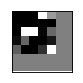

25K iteration loss: 
	target     = -0.3739782274

50K iteration loss: 
	target     = -0.4109826684

Max activation pattern for neuron #26


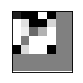

25K iteration loss: 
	target     = -0.9999996424

50K iteration loss: 
	target     = -0.9999999404

Max activation pattern for neuron #27


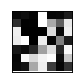

25K iteration loss: 
	target     = -0.9575154185

50K iteration loss: 
	target     = -0.9682453275

Max activation pattern for neuron #28


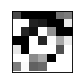

25K iteration loss: 
	target     = -0.9662278295

50K iteration loss: 
	target     = -0.9781430364

Max activation pattern for neuron #29


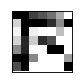

25K iteration loss: 
	target     = -0.9534168839

50K iteration loss: 
	target     = -0.9596282244

Max activation pattern for neuron #30


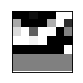

25K iteration loss: 
	target     = -0.9755051136

50K iteration loss: 
	target     = -0.9810730815

Max activation pattern for neuron #31


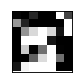

In [32]:
targets3 = []
for i in range(32):
    t = fit_image_to_activation((1,1,7,7), i, encoder2, n_iter=50_001, n_print=25_000)
    targets3.append(t)

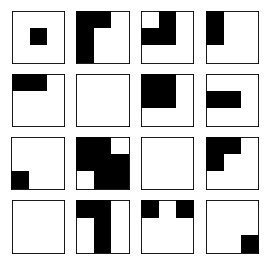

In [33]:
plot_mnist(F.tanh(torch.cat(targets1)).clamp(0,10).data.cpu().numpy(), (4,4))

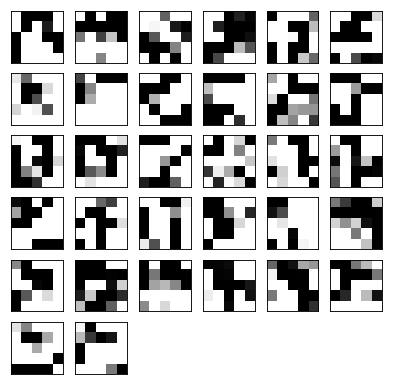

In [34]:
plot_mnist(F.tanh(torch.cat(targets2)).clamp(0,10).data.cpu().numpy(), (6,6))

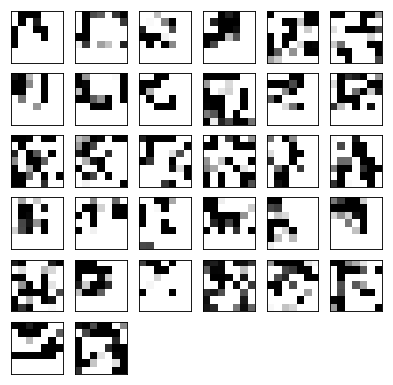

In [35]:
plot_mnist(F.tanh(torch.cat(targets3)).clamp(0,10).data.cpu().numpy(), (6,6))